In [2]:
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
from mpl_toolkits.mplot3d import axes3d
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib.colors import cnames
import pandas as pd
from scipy.optimize import bisect
from scipy import optimize
from scipy import interpolate

In [3]:
df=pd.read_csv('example_smiles_20230915_history.csv')
df.drop_duplicates(inplace=True)
df['Call']=np.where(df['call/put']=='C','C','P')
df['Put']=np.where(df['call/put']=='P','P','C')
df.head()

,Unnamed: 0,date,ticker,option_id,expiration,S0,div_yield,disc_rate,expiration_days,strike,implied_vol,delta,call/put,best_bid,best_offer,volume,Call,Put
0,444,2022-12-01,AAPL,142859004,2023-09-15,148.31,0.006136,0.048495,288,70.0,0.493286,-0.022411,P,0.55,0.72,8,P,P
1,443,2022-12-01,AAPL,141470480,2023-09-15,148.31,0.006136,0.048495,288,75.0,0.482260,-0.030015,P,0.74,0.99,1,P,P
2,442,2022-12-01,AAPL,141470481,2023-09-15,148.31,0.006136,0.048495,288,80.0,0.469062,-0.038711,P,1.00,1.25,1,P,P
3,441,2022-12-01,AAPL,141470482,2023-09-15,148.31,0.006136,0.048495,288,85.0,0.449848,-0.047315,P,1.15,1.56,0,P,P
4,449,2022-12-01,AAPL,141470483,2023-09-15,148.31,0.006136,0.048495,288,90.0,0.441822,-0.060800,P,1.67,1.90,17,P,P


In [4]:
#Defining our variables
K=df['strike']
S0=df['S0']
sigma=df['implied_vol']
date=df['date']
T=df['expiration_days']/365
r=df['disc_rate']
q=df['div_yield']
F_T = S0 * np.exp((r - q) * T)
x = np.log(K / F_T) #Log-forward moneyness

#Separating K, sigma, T, r, S0 between calls and puts to be used later
KC=df['strike'].where(df['call/put'] == 'C').dropna()
KP=df['strike'].where(df['call/put'] == 'P').dropna()
sigmaC=df['implied_vol'].where(df['call/put'] == 'C').dropna()
sigmaP=df['implied_vol'].where(df['call/put'] == 'P').dropna()
TC=T.where(df['call/put'] == 'C').dropna()
TP=T.where(df['call/put'] == 'P').dropna()
rC=r.where(df['call/put'] == 'C').dropna()
rP=r.where(df['call/put'] == 'P').dropna()
S0C=S0.where(df['call/put'] == 'C').dropna()
S0P=S0.where(df['call/put'] == 'P').dropna()

In [5]:
def BlackScholesCall(S0, K, T, r, sigma):
    d1 = (np.log(S0 / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call_price = S0 * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    return call_price

def BlackScholesPut(S0, K, T, r, sigma):
    d1 = (np.log(S0 / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    put_option_price = K * np.exp(-r * T) * norm.cdf(-d2) - S0 * norm.cdf(-d1)
    return put_option_price


def BSImpliedVolCall(S0, K, T, r, C):
    nK = len(K)
    sigmaL = np.full(nK, 1e-10)
    CL = BlackScholesCall(S0, K, T, r, sigmaL)
    sigmaH = np.full(nK, 10.0)
    CH = BlackScholesCall(S0, K, T, r, sigmaH)

    while np.mean(sigmaH - sigmaL) > 1e-10:
        sigma = (sigmaL + sigmaH) / 2
        CM = BlackScholesCall(S0, K, T, r, sigma)
        CL = CL + (CM < C) * (CM - CL)
        sigmaL = sigmaL + (CM < C) * (sigma - sigmaL)
        CH = CH + (CM >= C) * (CM - CH)
        sigmaH = sigmaH + (CM >= C) * (sigma - sigmaH)

    return sigma


def BSImpliedVolPut(S0, K, T, r, P):
    nK = len(K)
    sigmaL = np.full(nK, 1e-10)
    PL = BlackScholesPut(S0, K, T, r, sigmaL)
    sigmaH = np.full(nK, 10.0)
    PH = BlackScholesPut(S0, K, T, r, sigmaH)

    while np.mean(sigmaH - sigmaL) > 1e-10:
        sigma = (sigmaL + sigmaH) / 2
        PM = BlackScholesPut(S0, K, T, r, sigma)
        PL = PL + (PM < P) * (PM - PL)
        sigmaL = sigmaL + (PM < P) * (sigma - sigmaL)
        PH = PH + (PM >= P) * (PM - PH)
        sigmaH = sigmaH + (PM >= P) * (sigma - sigmaH)

    return sigma

In [6]:
CallOptVals=BlackScholesCall(S0C,KC,TC,rC,sigmaC).dropna() #Call Option Prices using BS
CallImpVols=BSImpliedVolCall(S0C,KC,TC,rC,C=CallOptVals) #Implied vols from Call Option Prices
PutOptVals=BlackScholesPut(S0P,KP,TP,rP,sigmaP).dropna() #Put Option Prices using BS
PutImpVols=BSImpliedVolPut(S0P,KP,TP,rP,P=PutOptVals)#Implied vols from Put Option Prices

print(CallImpVols)
print(PutImpVols)

16      0.333944
17      0.327819
18      0.321237
19      0.315741
20      0.310918
          ...   
5763    0.256532
5764    0.275267
5765    0.295142
5766    0.311538
5767    0.334614
Length: 2689, dtype: float64
0       0.493286
1       0.482260
2       0.469062
3       0.449848
4       0.441822
          ...   
5750    0.252269
5751    0.239666
5752    0.228342
5753    0.217859
5754    0.207538
Length: 2745, dtype: float64


In [7]:
#Merge together the implied volatilities
BSImpliedVol=pd.concat([CallImpVols,PutImpVols])
pd.Series.sort_values(BSImpliedVol) #Sort in ascending order
print(BSImpliedVol)

16      0.333944
17      0.327819
18      0.321237
19      0.315741
20      0.310918
          ...   
5750    0.252269
5751    0.239666
5752    0.228342
5753    0.217859
5754    0.207538
Length: 5434, dtype: float64


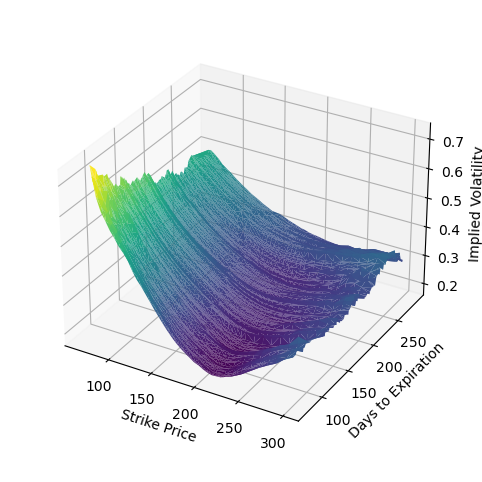

In [11]:
#Raw data surface
fig = plt.figure(figsize=(10, 6))
ax1 = fig.add_subplot(111, projection='3d')
ax1.plot_trisurf(K, df['expiration_days'], sigma, cmap='viridis')
ax1.set_box_aspect(aspect=None, zoom=0.9)
#ax1.set_title('AAPL 09/15/2023 Expiry')
ax1.set_xlabel('Strike Price')
ax1.set_ylabel('Days to Expiration')
ax1.set_zlabel('Implied Volatility')
plt.show()

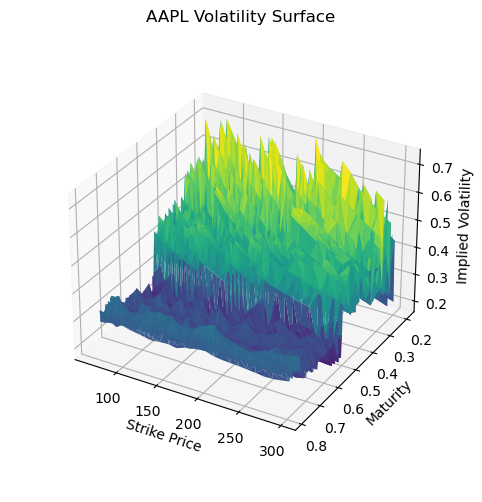

In [ ]:
#BS Implied Vols surface
fig = plt.figure(figsize=(10, 6))
ax2 = fig.add_subplot(111, projection='3d')
ax2.plot_trisurf(K, T, BSImpliedVol, cmap='viridis')
ax2.set_box_aspect(aspect=None, zoom=0.85)
ax2.set_title('AAPL Volatility Surface')
ax2.set_xlabel('Strike Price')
ax2.set_ylabel('Maturity')
ax2.set_zlabel('Implied Volatility')
ax2.invert_yaxis()
plt.show()

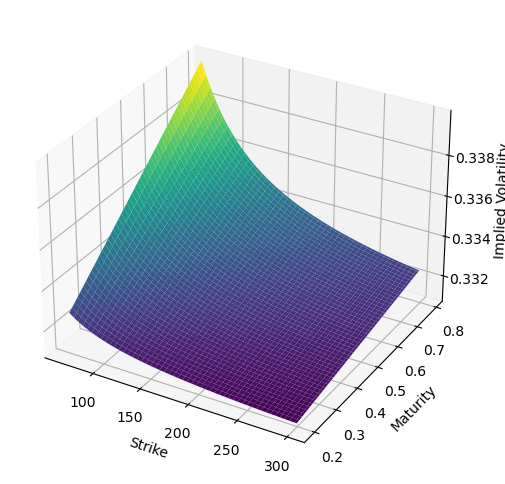

In [ ]:
#Using raw SVI parameterization
def svi_function(K, T, a, b, rho, m, sigma):
    return a + b * (rho * (K - m) + np.sqrt((K - m) ** 2 + sigma ** 2 * T))

# Parameters from gatheral paper Example 3.1
a, b, rho, sigma_0 = 0.1,1,0,-0.08

# Initial parameters as a NumPy array
K_array = K.to_numpy()
T_array = T.to_numpy()
x_array = x.to_numpy()  # Log-forward moneyness
sigma_array = sigma.to_numpy()
m=np.mean(x_array)  # Choose the average log-forward moneyness as initial guess for 'm'

# Function to minimize (sum of squared errors)
def svimse(params, K, T, sigma):
    a, b, rho, m = params
    # Calculate the squared errors between model and market implied volatilities
    errors = (sigma - svi_function(K, T, a, b, rho, x, sigma_0)) ** 2
    return np.sum(errors)

# Initial parameters as a NumPy array
initial_params = np.array([a, b, rho, m])

# Bounds for parameters to ensure reasonable values
bounds = [(None, None), (0, None), (-1, 1), (0, None)]

# Perform optimization to find the best-fitted parameters
result = optimize.minimize(svimse, initial_params, args=(K_array, T_array, sigma_array), bounds=bounds, method='L-BFGS-B', options={'maxiter': 1000})

# Extract the fitted parameters
fitted_params = result.x

#Create grid of strikes and maturies for SVI surface
K_grid = np.linspace(min(K), max(K), 100)
T_grid = np.linspace(min(T), max(T), 100)
K_grid, T_grid = np.meshgrid(K_grid, T_grid)

#Calculate the implied volatilities using the fitted SVI parameters
implied_vols_svi = svi_function(K_grid, T_grid, *fitted_params, sigma_0)

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(K_grid, T_grid, implied_vols_svi, cmap='viridis')
ax.set_xlabel('Strike')
ax.set_ylabel('Maturity')
ax.set_zlabel('Implied Volatility')
plt.show()